In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import xgboost as xgb
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scikitplot.metrics import plot_cumulative_gain, plot_confusion_matrix, plot_roc
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


In [36]:
def database(raw, hrv, sleepclass):
    raw_data = pd.read_csv(raw, sep = ',', decimal= '.')
    hrv_data = pd.read_csv(hrv, sep = ',', decimal = '.')
    sleepclass_data = pd.read_csv(sleepclass, sep = ',', decimal = '.', dtype = {'sleep_class': 'category'})
    df1 = raw_data.copy()
    df2 = hrv_data.copy()
    df3 = sleepclass_data.copy()
    
    #df1
    df1 = df1.drop(['at'], axis = 1)
    df1 = df1.set_index('timestamp')
    df1.head()
    #df2
    df2.columns = df2.columns.get_level_values(0)
    df2 = df2.set_index('timestamp')
    f_hrv = sp.interpolate.interp1d(df2.index, df2.to_numpy().T, kind = 'linear', fill_value=np.nan, bounds_error = False)
    tmp_data = f_hrv(df1.index).T
    df2 = pd.DataFrame(tmp_data, index = df1.index, columns = ['rmssd', 'tp', 'lfn', 'hfn', 'r_hrv'])
    df2.index = pd.to_datetime(df2.index, unit = 's')
    #df3
    df3 = df3.drop(['at'], axis = 1)
    df3.columns = df3.columns.get_level_values(0)
    df3 = df3.set_index('timestamp')
    f_class = sp.interpolate.interp1d(x = df3.index, y = df3.to_numpy().T, kind = 'previous',\
                                      fill_value=np.nan, bounds_error = False)
    tmp_data = f_class(df1.index).T
    df3 = pd.DataFrame(tmp_data, index = df1.index, columns = ['sleep_class'])
    df3.index = pd.to_datetime(df3.index, unit = 's')
    #df
    df1.index = pd.to_datetime(df1.index, unit = 's')
    df = pd.concat([df1, df2, df3], axis = 1)
    df['sleep_class'] = df['sleep_class'].fillna(5)
    
    df_tmp = df.copy()
    df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
    df_tmp = df_tmp.fillna(0)
    df_tmp['sleep_class'] = df['sleep_class'] 
    df = df_tmp.copy()
    
    return df

In [11]:
#Random Forest
def RFC(df):
    #modeling
    X = df.iloc[:, df.columns != 'sleep_class']
    y = df.iloc[:, df.columns == 'sleep_class'].squeeze()
    print('Night: '+ df.index[0].strftime('%d/%m/%Y %H: %m') + " - " + df.index[-1].strftime('%d/%m/%Y %H: %m'))
    print('Shape of X: {}'.format(X.shape))
    print('Shape of y: {}'.format(y.shape))
    
    #train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #feature scaling
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X = scaler.transform(X)
    
    #random forest
    rf = RandomForestClassifier(n_estimators = 800,
                            max_features = 'sqrt', 
                            max_depth = 12,
                            criterion = 'entropy',
                            min_samples_leaf=1,
                            min_samples_split=2,
                            random_state = 1,
                            verbose = 0)
    rf.fit(X_train, y_train)

    y_pre = rf.predict(X_test)
    print("Classification Report")
    print(classification_report(y_test, y_pre))
    plot_confusion_matrix(y_test, y_pre, title = "Confusion matrix: " + df.index[0].strftime('%d/%m/%Y') + \
                          ", score_accuracy:" +  np.round(accuracy_score(y_test, y_pre),3).astype('str'))
    
    return pd.Series(np.round(accuracy_score(y_test, y_pre),3))

In [12]:
#Gradient boosting
def GBC(df):
    #modeling
    X = df.iloc[:, df.columns != 'sleep_class']
    y = df.iloc[:, df.columns == 'sleep_class'].squeeze()
    print('Night: '+ df.index[0].strftime('%d/%m/%Y %H: %m') + " - " + df.index[-1].strftime('%d/%m/%Y %H: %m'))
    print('Shape of X: {}'.format(X.shape))
    print('Shape of y: {}'.format(y.shape))
    
    #train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #feature scaling
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X = scaler.transform(X)
    
    #gradient boosting
    gb_clf = GradientBoostingClassifier(n_estimators=300, 
                                    learning_rate=0.1, 
                                    max_features='sqrt', 
                                    max_depth=4, 
                                    criterion = 'friedman_mse',
                                    random_state=0)
    gb_clf.fit(X_train, y_train)

    y_pre = gb_clf.predict(X_test)
    
    print("Classification Report")
    print(classification_report(y_test, y_pre))
    plot_confusion_matrix(y_test, y_pre, title = "Confusion matrix: " + df.index[0].strftime('%d/%m/%Y') + \
                          ", score_accuracy:" +  np.round(accuracy_score(y_test, y_pre),3).astype('str'))
    
    return pd.Series(np.round(accuracy_score(y_test, y_pre),3))

In [37]:
#XGB
def XGB(df):
    #modeling
    X = df.iloc[:, df.columns != 'sleep_class']
    y = df.iloc[:, df.columns == 'sleep_class'].squeeze()
    print('Night: '+ df.index[0].strftime('%d/%m/%Y %H: %m') + " - " + df.index[-1].strftime('%d/%m/%Y %H: %m'))
    print('Shape of X: {}'.format(X.shape))
    print('Shape of y: {}'.format(y.shape))
    
    #train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #feature scaling
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #X = scaler.transform(X)
    
    #train_set and test_set for xgb
    y_train = pd.to_numeric(y_train-1)
    y_test = pd.to_numeric(y_test-1)
    
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)
    
    #XBG
    param = {
    'eta': 0.3, 
    'max_depth': 8,  
    'min_child_weight': 2,
    'objective': 'multi:softprob',  
    'num_class': 5} 

    steps = 20  # The number of training iterations

    model = xgb.train(param, D_train, steps)

    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print(classification_report(y_test, best_preds))
    plot_confusion_matrix(y_test, best_preds, title = "Confusion matrix: " + df.index[0].strftime('%d/%m/%Y') + \
                          ", score_accuracy:" +  np.round(accuracy_score(y_test, best_preds),3).astype('str'))
    
    return pd.Series(np.round(accuracy_score(y_test, best_preds),3))

In [6]:
def feature_imp(df, rf):
    df2 = df.copy()
    df2 = df2.drop('sleep_class', axis = 1)
    feature_imp = pd.Series(rf.feature_importances_, index = df2.columns).sort_values(ascending = False)
    
    sns.barplot(x = feature_imp[0:9], y = feature_imp.index[0:9])
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()

## Performances

In [14]:
data_raw = ['2020-05-27--20.37-08.55-vitals.csv', '2020-05-28--22.22-07.57-vitals.csv', 
            '2020-05-29--21.01-09.06-vitals.csv', '2020-05-30--22.27-08.35-vitals.csv', 
            '2020-05-31--22.53-08.53-vitals.csv', '2020-06-01--21.28-07.19-vitals.csv', 
            '2020-06-02--21.03-07.39-vitals.csv', '2020-06-03--21.22-07.49-vitals.csv', 
            '2020-06-04--19.50-07.13-vitals.csv', '2020-06-05--22.23-08.40-vitals.csv', 
            '2020-06-06--21.58-08.32-vitals.csv', '2020-06-07--21.40-07.45-vitals.csv', 
            '2020-06-11--22.11-08.55-vitals.csv', '2020-06-14--21.05-08.54-vitals.csv', 
            '2020-06-16--03.18-08.49-vitals.csv', '2020-06-16--23.05-10.40-vitals.csv', 
            '2020-06-17--23.22-10.26-vitals.csv', '2020-06-21--21.44-08.41-vitals.csv', 
            '2020-06-22--23.16-08.32-vitals.csv', '2020-06-23--22.22-09.37-vitals.csv', 
            '2020-06-24--22.51-09.06-vitals.csv', '2020-06-25--22.35-09.39-vitals.csv']

data_hrv = ['2020-05-27--20.37-08.55-hrv.csv', '2020-05-28--22.22-07.57-hrv.csv', 
            '2020-05-29--21.01-09.06-hrv.csv', '2020-05-30--22.27-08.35-hrv.csv', 
            '2020-05-31--22.53-08.53-hrv.csv', '2020-06-01--21.28-07.19-hrv.csv', 
            '2020-06-02--21.03-07.39-hrv.csv', '2020-06-03--21.22-07.49-hrv.csv', 
            '2020-06-04--19.50-07.13-hrv.csv', '2020-06-05--22.23-08.40-hrv.csv', 
            '2020-06-06--21.58-08.32-hrv.csv', '2020-06-07--21.40-07.45-hrv.csv', 
            '2020-06-11--22.11-08.55-hrv.csv', '2020-06-14--21.05-08.54-hrv.csv', 
            '2020-06-16--03.18-08.49-hrv.csv', '2020-06-16--23.05-10.40-hrv.csv', 
            '2020-06-17--23.22-10.26-hrv.csv', '2020-06-21--21.44-08.41-hrv.csv', 
            '2020-06-22--23.16-08.32-hrv.csv', '2020-06-23--22.22-09.37-hrv.csv', 
            '2020-06-24--22.51-09.06-hrv.csv', '2020-06-25--22.35-09.39-hrv.csv']

data_sleepclass = ['2020-05-27--20.37-08.55-sleepclasses.csv', '2020-05-28--22.22-07.57-sleepclasses.csv', 
             '2020-05-29--21.01-09.06-sleepclasses.csv', '2020-05-30--22.27-08.35-sleepclasses.csv', 
             '2020-05-31--22.53-08.53-sleepclasses.csv', '2020-06-01--21.28-07.19-sleepclasses.csv', 
             '2020-06-02--21.03-07.39-sleepclasses.csv', '2020-06-03--21.22-07.49-sleepclasses.csv', 
             '2020-06-04--19.50-07.13-sleepclasses.csv', '2020-06-05--22.23-08.40-sleepclasses.csv', 
             '2020-06-06--21.58-08.32-sleepclasses.csv', '2020-06-07--21.40-07.45-sleepclasses.csv', 
             '2020-06-11--22.11-08.55-sleepclasses.csv', '2020-06-14--21.05-08.54-sleepclasses.csv', 
             '2020-06-16--03.18-08.49-sleepclasses.csv', '2020-06-16--23.05-10.40-sleepclasses.csv', 
             '2020-06-17--23.22-10.26-sleepclasses.csv', '2020-06-21--21.44-08.41-sleepclasses.csv', 
             '2020-06-22--23.16-08.32-sleepclasses.csv', '2020-06-23--22.22-09.37-sleepclasses.csv', 
             '2020-06-24--22.51-09.06-sleepclasses.csv', '2020-06-25--22.35-09.39-sleepclasses.csv']

### Random Forest

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Night: 27/05/2020 19: 05 - 28/05/2020 07: 05
Shape of X: (10936, 8)
Shape of y: (10936,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.93      0.88      0.90       526
         2.0       0.92      0.96      0.94      1534
         3.0       0.94      0.92      0.93       815
         4.0       0.94      0.88      0.91       368
         5.0       1.00      0.89      0.94        38

    accuracy                           0.93      3281
   macro avg       0.95      0.91      0.93      3281
weighted avg       0.93      0.93      0.93      3281

Night: 28/05/2020 21: 05 - 29/05/2020 06: 05
Shape of X: (8471, 8)
Shape of y: (8471,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.96      0.91      0.93       353
         2.0       0.92      0.98      0.95      1216
         3.0       0.95      0.86      0.90       478
         4.0       0.93      0.93      0.93       286
         5.0       0

Night: 16/06/2020 01: 06 - 16/06/2020 06: 06
Shape of X: (4850, 8)
Shape of y: (4850,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.98      0.72      0.83       166
         2.0       0.88      0.96      0.92       683
         3.0       0.97      0.93      0.95       271
         4.0       0.94      0.91      0.93       269
         5.0       0.97      0.88      0.92        66

    accuracy                           0.92      1455
   macro avg       0.95      0.88      0.91      1455
weighted avg       0.92      0.92      0.92      1455

Night: 16/06/2020 21: 06 - 17/06/2020 08: 06
Shape of X: (10335, 8)
Shape of y: (10335,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.96      0.93      0.94       480
         2.0       0.95      0.97      0.96      1649
         3.0       0.95      0.92      0.94       725
         4.0       0.93      0.93      0.93       224
         5.0       1

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Night: 25/06/2020 20: 06 - 26/06/2020 07: 06
Shape of X: (9713, 8)
Shape of y: (9713,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.93       580
         2.0       0.94      0.97      0.95      1368
         3.0       0.97      0.90      0.93       466
         4.0       0.97      0.96      0.96       362
         5.0       0.93      0.92      0.93       138

    accuracy                           0.94      2914
   macro avg       0.95      0.93      0.94      2914
weighted avg       0.94      0.94      0.94      2914

Average_accuracy: 0.939


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


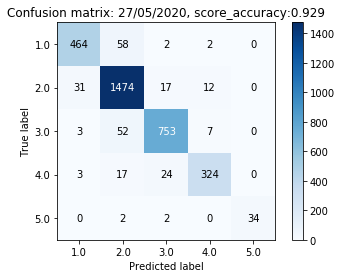

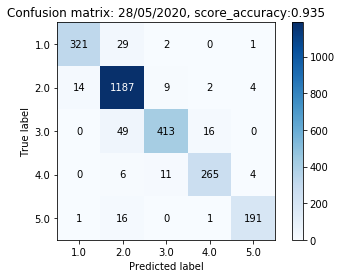

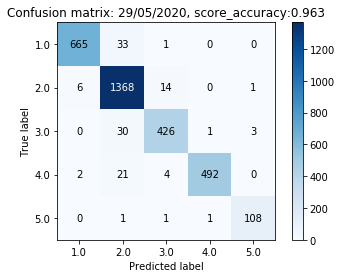

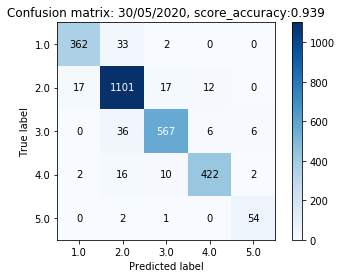

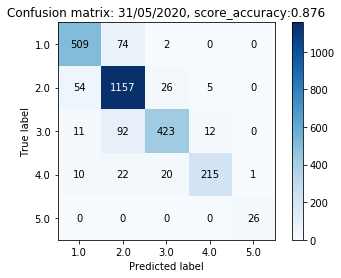

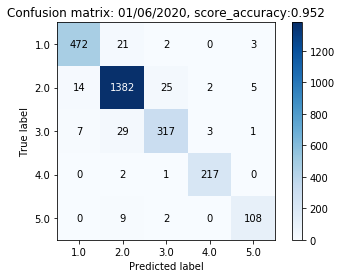

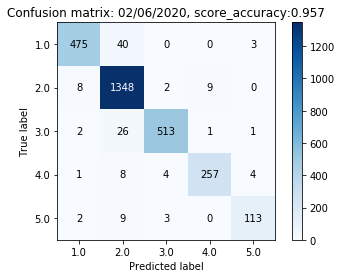

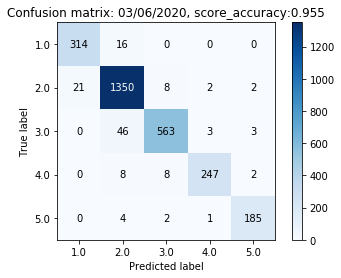

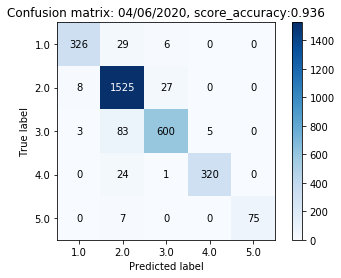

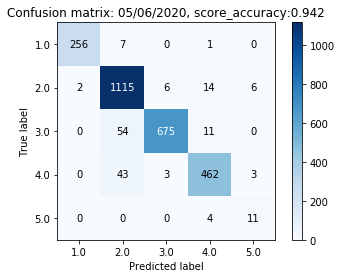

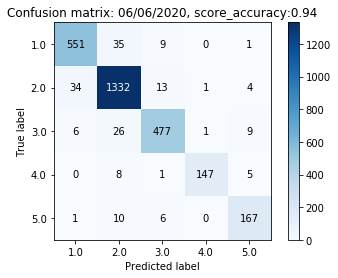

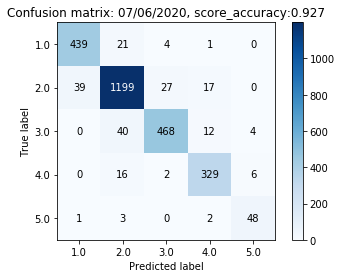

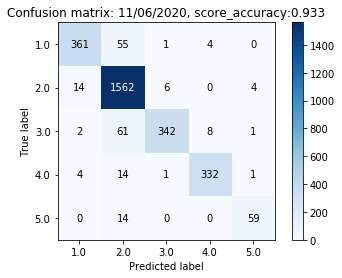

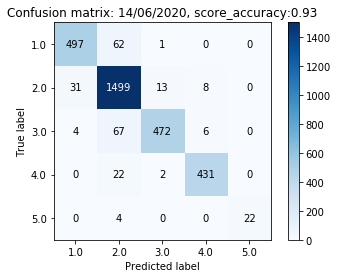

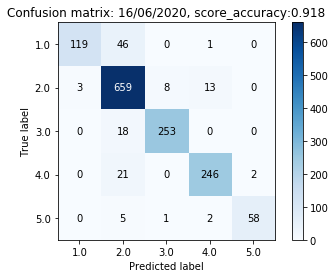

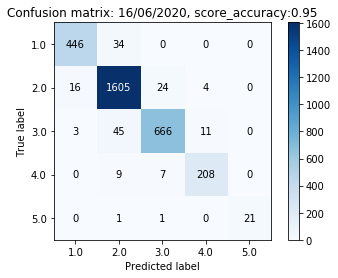

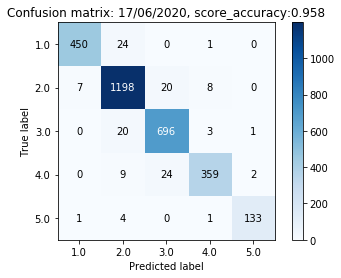

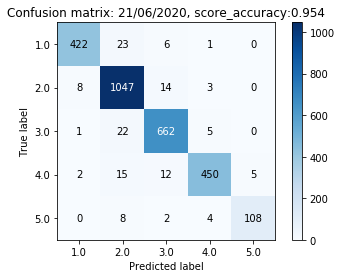

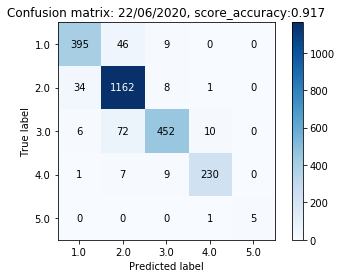

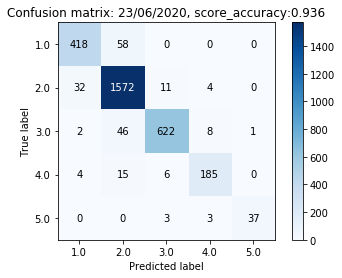

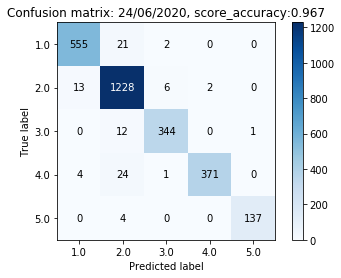

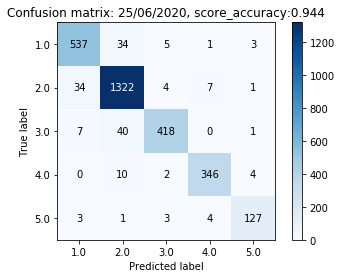

In [8]:
series_accuracy = pd.Series()

for a, b, c in zip(data_raw, data_hrv, data_sleepclass):
    df = database(a, b, c)
    series_accuracy = series_accuracy.append(RFC(df), ignore_index = True)
    
print('Average_accuracy: '+ str(series_accuracy.mean()))

### Gradient boosting

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Night: 27/05/2020 19: 05 - 28/05/2020 07: 05
Shape of X: (10936, 8)
Shape of y: (10936,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.94      0.88      0.91       526
         2.0       0.91      0.96      0.94      1534
         3.0       0.93      0.92      0.92       815
         4.0       0.94      0.87      0.90       368
         5.0       1.00      0.95      0.97        38

    accuracy                           0.93      3281
   macro avg       0.95      0.91      0.93      3281
weighted avg       0.93      0.93      0.92      3281

Night: 28/05/2020 21: 05 - 29/05/2020 06: 05
Shape of X: (8471, 8)
Shape of y: (8471,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.94       353
         2.0       0.94      0.96      0.95      1216
         3.0       0.92      0.87      0.89       478
         4.0       0.92      0.91      0.91       286
         5.0       0

Classification Report
              precision    recall  f1-score   support

         1.0       0.96      0.77      0.86       166
         2.0       0.91      0.98      0.94       683
         3.0       0.97      0.94      0.96       271
         4.0       0.95      0.94      0.95       269
         5.0       0.97      0.92      0.95        66

    accuracy                           0.94      1455
   macro avg       0.95      0.91      0.93      1455
weighted avg       0.94      0.94      0.94      1455

Night: 16/06/2020 21: 06 - 17/06/2020 08: 06
Shape of X: (10335, 8)
Shape of y: (10335,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.96      0.94      0.95       480
         2.0       0.95      0.97      0.96      1649
         3.0       0.94      0.92      0.93       725
         4.0       0.93      0.93      0.93       224
         5.0       1.00      0.87      0.93        23

    accuracy                           0.95      310

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Night: 25/06/2020 20: 06 - 26/06/2020 07: 06
Shape of X: (9713, 8)
Shape of y: (9713,)
Classification Report
              precision    recall  f1-score   support

         1.0       0.96      0.93      0.95       580
         2.0       0.94      0.98      0.96      1368
         3.0       0.95      0.88      0.92       466
         4.0       0.95      0.96      0.96       362
         5.0       0.93      0.90      0.92       138

    accuracy                           0.95      2914
   macro avg       0.95      0.93      0.94      2914
weighted avg       0.95      0.95      0.95      2914

Average_accuracy: 0.9381818181818182


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


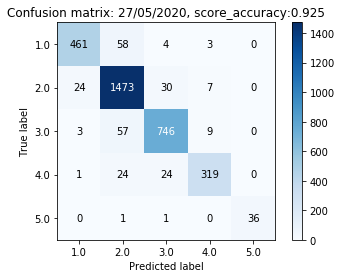

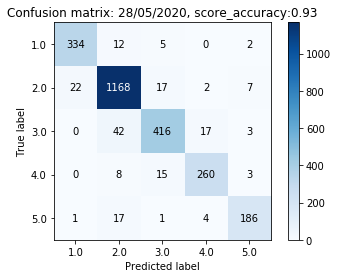

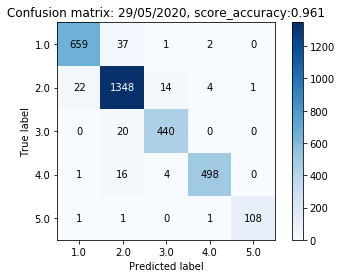

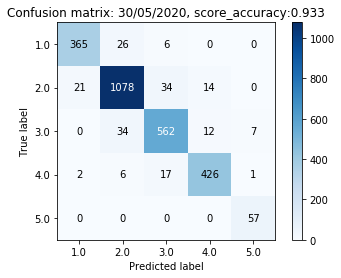

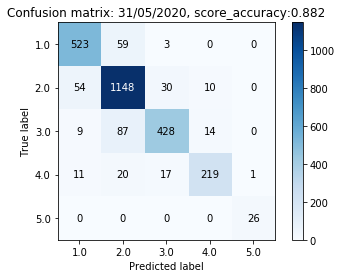

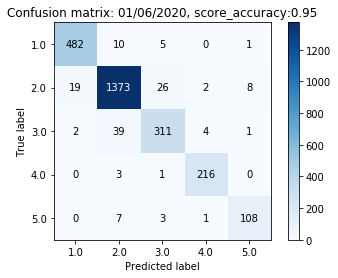

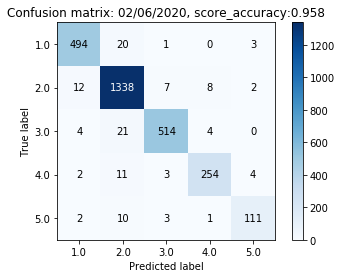

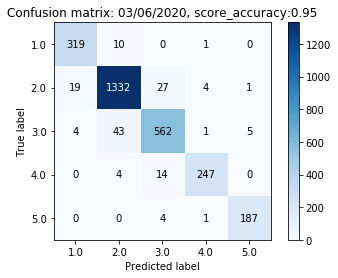

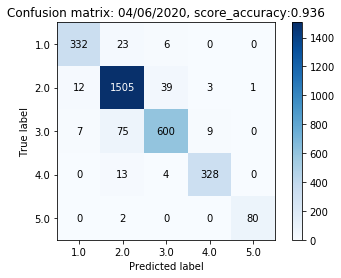

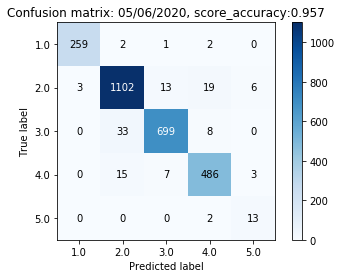

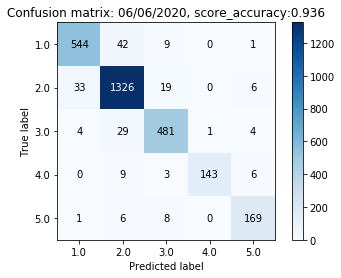

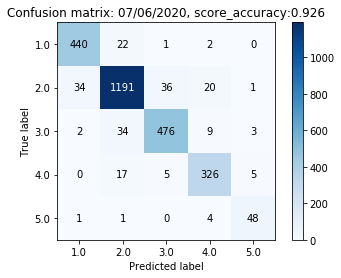

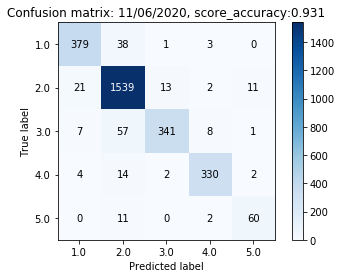

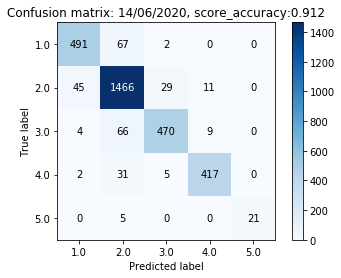

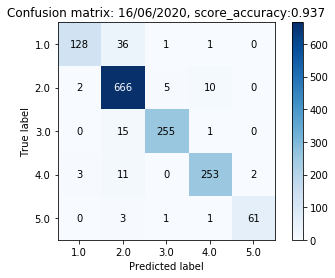

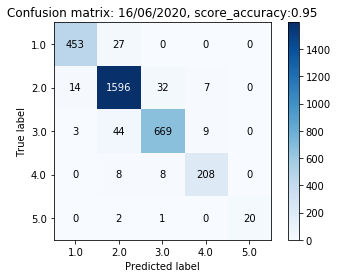

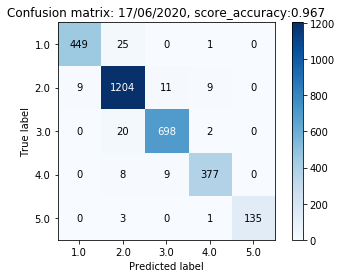

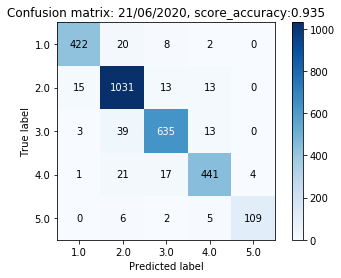

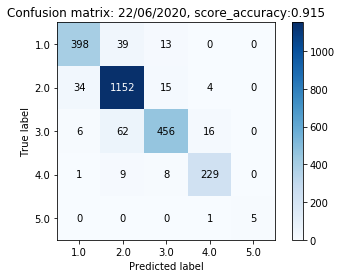

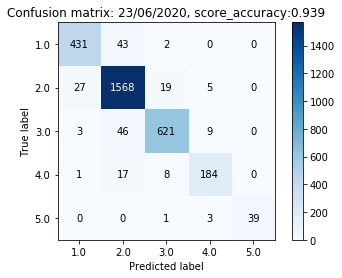

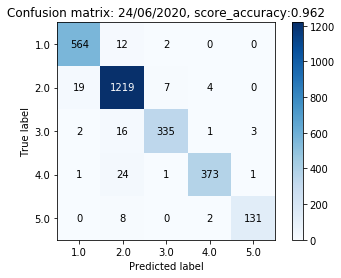

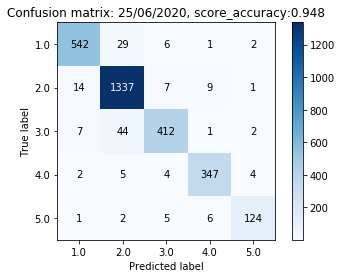

In [9]:
series_accuracy = pd.Series()

for a, b, c in zip(data_raw, data_hrv, data_sleepclass):
    df = database(a, b, c)
    series_accuracy = series_accuracy.append(GBC(df), ignore_index = True)
    
print('Average_accuracy: '+ str(series_accuracy.mean()))

### XGB

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Night: 27/05/2020 19: 05 - 28/05/2020 07: 05
Shape of X: (10936, 8)
Shape of y: (10936,)
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       526
         1.0       0.91      0.96      0.93      1534
         2.0       0.93      0.91      0.92       815
         3.0       0.93      0.86      0.89       368
         4.0       0.94      0.87      0.90        38

    accuracy                           0.92      3281
   macro avg       0.93      0.90      0.91      3281
weighted avg       0.92      0.92      0.92      3281

Night: 28/05/2020 21: 05 - 29/05/2020 06: 05
Shape of X: (8471, 8)
Shape of y: (8471,)
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       353
         1.0       0.94      0.96      0.95      1216
         2.0       0.92      0.86      0.89       478
         3.0       0.90      0.88      0.89       286
         4.0       0.87      0.91      0.89       209

    accur

Night: 16/06/2020 21: 06 - 17/06/2020 08: 06
Shape of X: (10335, 8)
Shape of y: (10335,)
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93       480
         1.0       0.95      0.96      0.95      1649
         2.0       0.93      0.91      0.92       725
         3.0       0.94      0.92      0.93       224
         4.0       0.96      0.96      0.96        23

    accuracy                           0.94      3101
   macro avg       0.94      0.94      0.94      3101
weighted avg       0.94      0.94      0.94      3101

Night: 17/06/2020 21: 06 - 18/06/2020 08: 06
Shape of X: (9867, 8)
Shape of y: (9867,)
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       475
         1.0       0.96      0.98      0.97      1233
         2.0       0.97      0.97      0.97       720
         3.0       0.95      0.93      0.94       394
         4.0       0.98      0.96      0.97       139

    accur

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Night: 25/06/2020 20: 06 - 26/06/2020 07: 06
Shape of X: (9713, 8)
Shape of y: (9713,)
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       580
         1.0       0.95      0.98      0.96      1368
         2.0       0.95      0.90      0.92       466
         3.0       0.95      0.95      0.95       362
         4.0       0.92      0.90      0.91       138

    accuracy                           0.95      2914
   macro avg       0.95      0.93      0.94      2914
weighted avg       0.95      0.95      0.95      2914



D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Average_accuracy: 0.9371818181818182


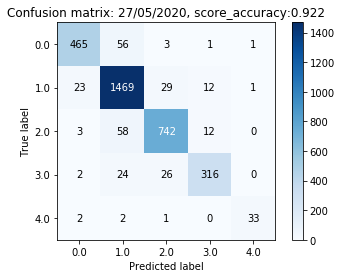

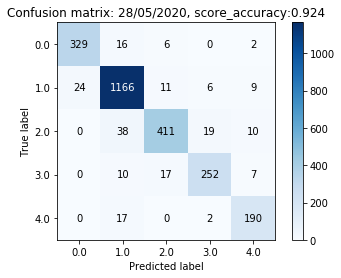

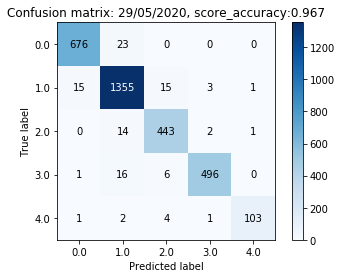

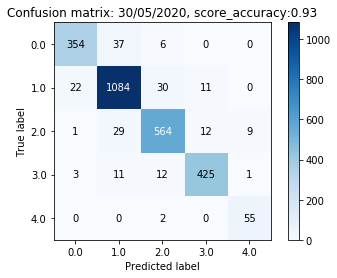

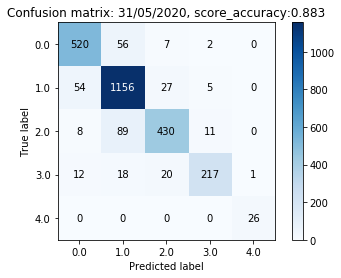

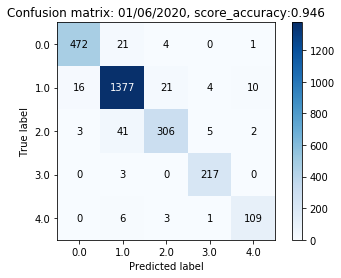

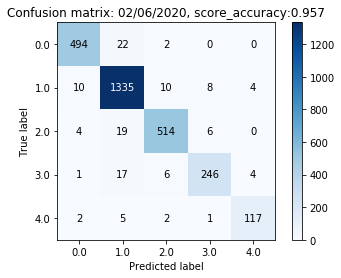

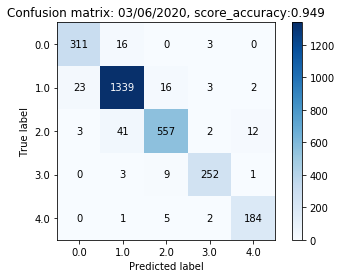

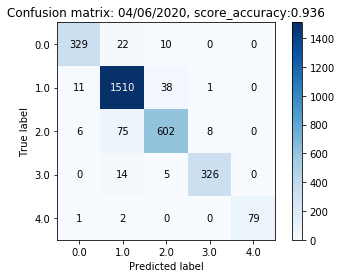

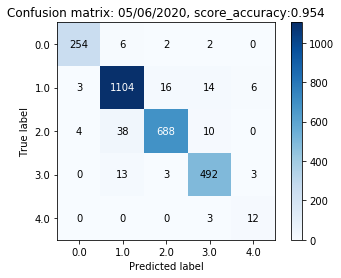

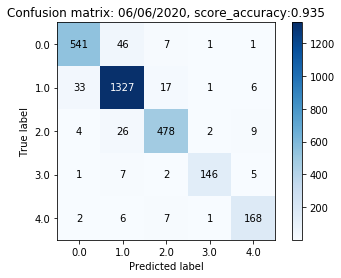

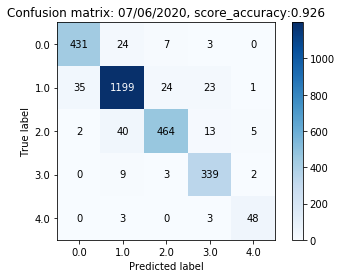

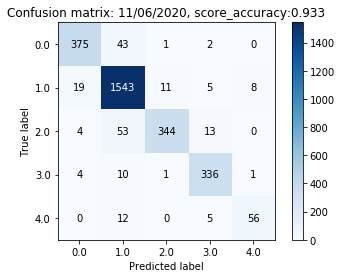

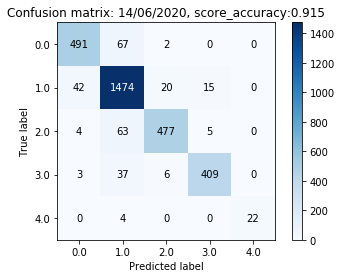

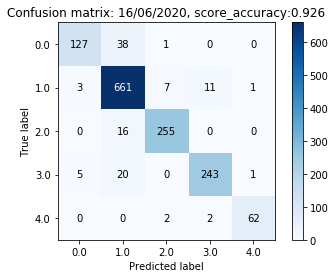

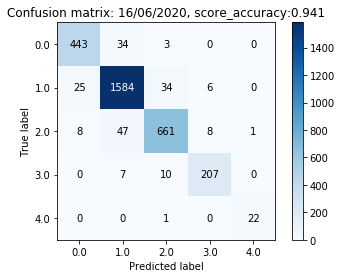

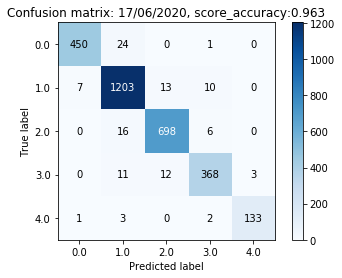

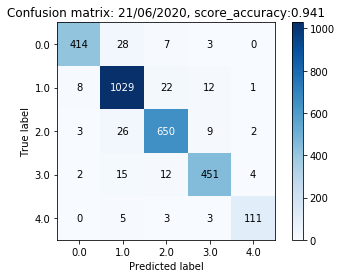

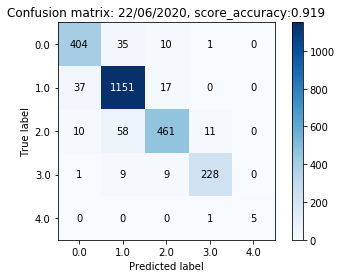

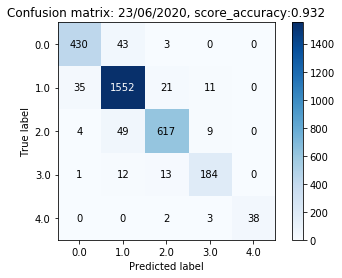

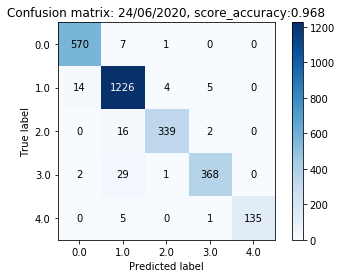

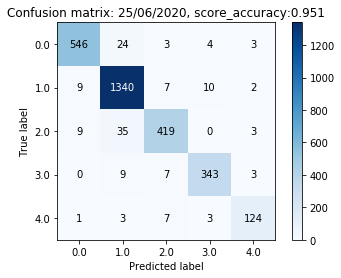

In [38]:
series_accuracy = pd.Series()

for a, b, c in zip(data_raw, data_hrv, data_sleepclass):
    df = database(a, b, c)
    series_accuracy = series_accuracy.append(XGB(df), ignore_index = True)
    
print('Average_accuracy: '+ str(series_accuracy.mean()))

## Test de performance sur l'ensemble des nuits

In [11]:
def error_XGB(i ,j):
        df_train = database(data_raw[i], data_hrv[i], data_sleepclass[i])
        df_test = database(data_raw[j], data_hrv[j], data_sleepclass[j])

        df_tmp = df_train.copy()
        df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
        df_tmp = df_tmp.fillna(0)
        df_tmp['sleep_class'] = df_train['sleep_class'] 
        df_train = df_tmp.copy()

        df_tmp = df_test.copy()
        df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
        df_tmp = df_tmp.fillna(0)
        df_tmp['sleep_class'] = df_test['sleep_class'] 
        df_test = df_tmp.copy()

        #modeling
        X_train = df_train.iloc[:, df_train.columns != 'sleep_class']
        y_train = df_train.iloc[:, df_train.columns == 'sleep_class'].squeeze()

        X_test = df_test.iloc[:, df_test.columns != 'sleep_class']
        y_test = df_test.iloc[:, df_test.columns == 'sleep_class'].squeeze()
        #cross-validation
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

        #feature scaling
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        #X = scaler.transform(X)
        
        #train_set and test_set for xgb
        y_train = pd.to_numeric(y_train-1)
        y_test = pd.to_numeric(y_test-1)

        D_train = xgb.DMatrix(X_train, label=y_train)
        D_test = xgb.DMatrix(X_test, label=y_test)

        #XBG
        param = {
        'eta': 0.3, 
        'max_depth': 8,  
        'min_child_weight': 2,
        'objective': 'multi:softprob',  
        'num_class': 5} 

        steps = 20  # The number of training iterations

        model = xgb.train(param, D_train, steps)

        preds = model.predict(D_test)
        best_preds = np.asarray([np.argmax(line) for line in preds])
        
        return (1-accuracy_score(y_test, best_preds))

In [12]:
#train_test_split

train_set_size = round(len(data_raw)/100 *75)
test_set_size = len(data_raw) - train_set_size

#train_set, il doit d'utiliser Random.shuffle()...
seed = random.randint(1, 50)
#print('seed = ', seed)
random.seed(seed)
train_set_raw = random.sample(data_raw, k = train_set_size)
#print('train_set_raw: ', train_set_raw)

random.seed(seed)
train_set_hrv = random.sample(data_hrv, k = train_set_size)
#print('train_set_hrv: ', train_set_hrv)

random.seed(seed)
train_set_sleepclass = random.sample(data_sleepclass, k = train_set_size)
#print('train_set_sleepclass: ', train_set_sleepclass)

#test_set
test_set_raw = [x for x in data_raw if x not in train_set_raw]
test_set_hrv = [x for x in data_hrv if x not in train_set_hrv]
test_set_sleepclass = [x for x in data_sleepclass if x not in train_set_sleepclass]

In [13]:
error_model = []
for i in range(len(train_set_raw)):
    error = []
    for j in [x for x in range(len(data_raw)) if x != i]:
        error.append(error_XGB(i ,j))
    error_model.append(np.mean(error))
error_model = np.array(error_model)
print(error_model)
np.argmin(error_model) 

[0.56693597 0.53859658 0.57489376 0.61249813 0.5573417  0.56382774
 0.60976116 0.62793508 0.57631019 0.61049931 0.5500571  0.5645165
 0.53371766 0.54621272 0.52624548 0.59149421]


14

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

         0.0       0.07      0.00      0.00      1693
         1.0       0.57      0.88      0.69      4681
         2.0       0.00      0.00      0.00      1193
         3.0       0.24      0.30      0.27       744
         4.0       0.25      0.14      0.18       429

    accuracy                           0.50      8740
   macro avg       0.23      0.27      0.23      8740
weighted avg       0.35      0.50      0.40      8740

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1830
         1.0       0.49      0.89      0.63      4420
         2.0       0.35      0.05      0.09      1777
         3.0       0.13      0.12      0.12       924
         4.0       0.16      0.07      0.10       477

    accuracy                           0.44      9428
   macro avg       0.23      0.23      0.19      9428
weighted avg       0.32      0.44      0.33      9428

              precisio

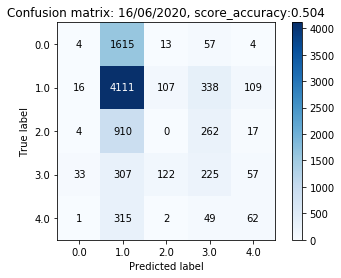

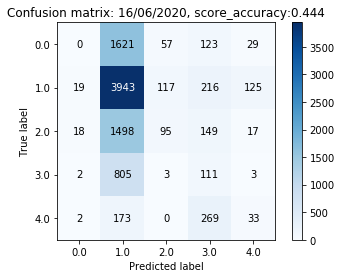

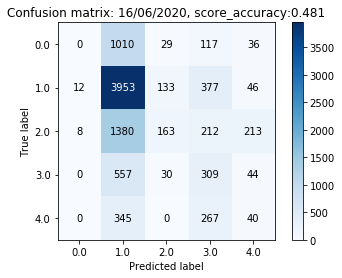

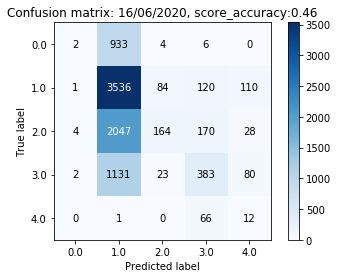

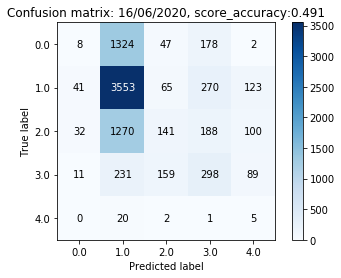

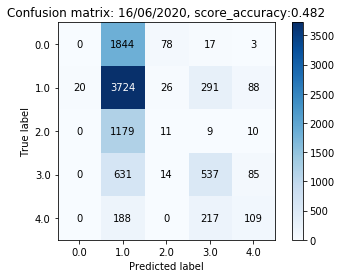

In [14]:
series_accuracy = pd.Series()
for i in range(len(test_set_raw)):
    df_train = database(data_raw[14], data_hrv[14], data_sleepclass[14])
    df_test = database(test_set_raw[i], test_set_hrv[i], test_set_sleepclass[i])

    df_tmp = df_train.copy()
    df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
    df_tmp = df_tmp.fillna(0)
    df_tmp['sleep_class'] = df_train['sleep_class'] 
    df_train = df_tmp.copy()

    df_tmp = df_test.copy()
    df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
    df_tmp = df_tmp.fillna(0)
    df_tmp['sleep_class'] = df_test['sleep_class'] 
    df_test = df_tmp.copy()

    #modeling
    X_train = df_train.iloc[:, df_train.columns != 'sleep_class']
    y_train = df_train.iloc[:, df_train.columns == 'sleep_class'].squeeze()

    X_test = df_test.iloc[:, df_test.columns != 'sleep_class']
    y_test = df_test.iloc[:, df_test.columns == 'sleep_class'].squeeze()
    
    #feature scaling
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #X = scaler.transform(X)
    
    #train_set and test_set for xgb
    y_train = pd.to_numeric(y_train-1)
    y_test = pd.to_numeric(y_test-1)

    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)

    #XBG
    param = {
    'eta': 0.3, 
    'max_depth': 8,  
    'min_child_weight': 2,
    'objective': 'multi:softprob',  
    'num_class': 5} 

    steps = 20  # The number of training iterations

    model = xgb.train(param, D_train, steps)

    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print(classification_report(y_test, best_preds))
    plot_confusion_matrix(y_test, best_preds, title = "Confusion matrix: " + df_train.index[0].strftime('%d/%m/%Y') + \
                          ", score_accuracy:" +  np.round(accuracy_score(y_test, best_preds),3).astype('str'))
    
    score_tmp = pd.Series(np.round(accuracy_score(y_test, best_preds),3))
    series_accuracy = series_accuracy.append(score_tmp, ignore_index = True)

print('Average_accuracy: ', series_accuracy.mean())

### Upsampling

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
def error_XGB(i ,j):
        df_train = database(data_raw[i], data_hrv[i], data_sleepclass[i])
        df_test = database(data_raw[j], data_hrv[j], data_sleepclass[j])

        df_tmp = df_train.copy()
        df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
        df_tmp = df_tmp.fillna(0)
        df_tmp['sleep_class'] = df_train['sleep_class'] 
        df_train = df_tmp.copy()

        df_tmp = df_test.copy()
        df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
        df_tmp = df_tmp.fillna(0)
        df_tmp['sleep_class'] = df_test['sleep_class'] 
        df_test = df_tmp.copy()

        #modeling
        X_train = df_train.iloc[:, df_train.columns != 'sleep_class']
        y_train = df_train.iloc[:, df_train.columns == 'sleep_class'].squeeze()

        X_test = df_test.iloc[:, df_test.columns != 'sleep_class']
        y_test = df_test.iloc[:, df_test.columns == 'sleep_class'].squeeze()
        
        #upsampling with smote
        sm = SMOTE(random_state = 5, k_neighbors = 4)
        X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
        

        #feature scaling
        scaler = preprocessing.StandardScaler()
        X_train_res = scaler.fit_transform(X_train_res)
        X_test = scaler.transform(X_test)
        #X = scaler.transform(X)
        
        #train_set and test_set for xgb
        y_train_res = pd.to_numeric(y_train_res-1)
        y_test = pd.to_numeric(y_test-1)

        D_train = xgb.DMatrix(X_train_res, label=y_train_res)
        D_test = xgb.DMatrix(X_test, label=y_test)

        #XBG
        param = {
        'eta': 0.3, 
        'max_depth': 8,  
        'min_child_weight': 2,
        'objective': 'multi:softprob',  
        'num_class': 5} 

        steps = 20  # The number of training iterations

        model = xgb.train(param, D_train, steps)

        preds = model.predict(D_test)
        best_preds = np.asarray([np.argmax(line) for line in preds])
        
        return (1-accuracy_score(y_test, best_preds))

In [17]:
error_model = []
for i in range(len(train_set_raw)):
    error = []
    for j in [x for x in range(len(data_raw)) if x != i]:
        error.append(error_XGB(i ,j))
    error_model.append(np.mean(error))
error_model = np.array(error_model)
print(error_model)
np.argmin(error_model) 

KeyboardInterrupt: 

In [ ]:
series_accuracy = pd.Series()
for i in range(len(test_set_raw)):
    df_train = database(data_raw[14], data_hrv[14], data_sleepclass[14])
    df_test = database(test_set_raw[i], test_set_hrv[i], test_set_sleepclass[i])

    df_tmp = df_train.copy()
    df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
    df_tmp = df_tmp.fillna(0)
    df_tmp['sleep_class'] = df_train['sleep_class'] 
    df_train = df_tmp.copy()

    df_tmp = df_test.copy()
    df_tmp = df_tmp.drop(['sleep_class'], axis = 1)
    df_tmp = df_tmp.fillna(0)
    df_tmp['sleep_class'] = df_test['sleep_class'] 
    df_test = df_tmp.copy()

    #modeling
    X_train = df_train.iloc[:, df_train.columns != 'sleep_class']
    y_train = df_train.iloc[:, df_train.columns == 'sleep_class'].squeeze()

    X_test = df_test.iloc[:, df_test.columns != 'sleep_class']
    y_test = df_test.iloc[:, df_test.columns == 'sleep_class'].squeeze()
    
    #feature scaling
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #X = scaler.transform(X)
    
    #train_set and test_set for xgb
    y_train = pd.to_numeric(y_train-1)
    y_test = pd.to_numeric(y_test-1)

    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)

    #XBG
    param = {
    'eta': 0.3, 
    'max_depth': 8,  
    'min_child_weight': 2,
    'objective': 'multi:softprob',  
    'num_class': 5} 

    steps = 20  # The number of training iterations

    model = xgb.train(param, D_train, steps)

    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print(classification_report(y_test, best_preds))
    plot_confusion_matrix(y_test, best_preds, title = "Confusion matrix: " + df_train.index[0].strftime('%d/%m/%Y') + \
                          ", score_accuracy:" +  np.round(accuracy_score(y_test, best_preds),3).astype('str'))
    
    score_tmp = pd.Series(np.round(accuracy_score(y_test, best_preds),3))
    series_accuracy = series_accuracy.append(score_tmp, ignore_index = True)

print('Average_accuracy: ', series_accuracy.mean())